In [18]:
MAX_FRAMES = 100
PATH = "./refracting-spheres"

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def to_numpy(conf, skip_last: bool = False):
    for e, values in conf.items():
        conf[e] = np.array(values)[1:] if not skip_last else np.array(values)[1:-1]

    return conf

file = json.load(open("{}/errors.json".format(PATH)))
frame_steps: int = file["frame_steps"]
confs = file["errors"]
hero = to_numpy(confs["hero"])
random = to_numpy(confs["random"], True)

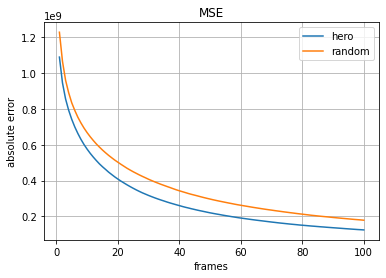

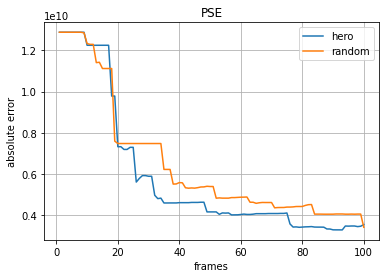

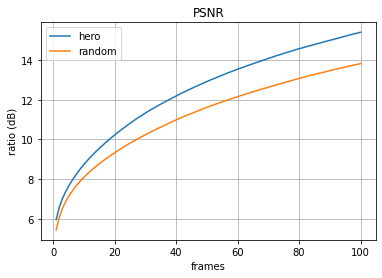

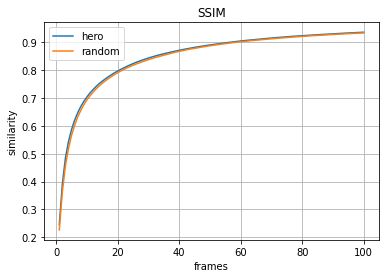

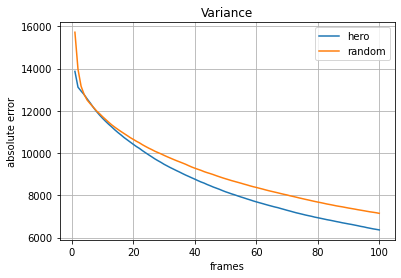

In [21]:
# Raw error plots

def plot_conf(plots, conf, label):
    for e, y in conf.items():
        max_len = np.minimum(len(y), MAX_FRAMES)
        y = y[:max_len]
        x = np.arange(1, len(y) * frame_steps + 1, frame_steps)

        ax = plots[e][1]
        ax.plot(x, y, label=label)

        ax.grid(visible=True)
        ax.set_xlabel('frames')
        ax.set_title("Variance" if e == "VAR" else e)
        ax.legend()

        if e == "SSIM":
            ax.set_ylabel("similarity")
        elif e == "PSNR":
            ax.set_ylabel("ratio (dB)")
        else:
            ax.set_ylabel("absolute error")

error_plots = {
    "MSE": plt.subplots(),
    "PSE": plt.subplots(),
    "PSNR": plt.subplots(),
    "SSIM": plt.subplots(),
    "VAR": plt.subplots(),
}

plot_conf(error_plots, hero, "hero")
plot_conf(error_plots, random, "random")
for e, p in error_plots.items():
    p[0].savefig("{}/{}.png".format(PATH, "Variance" if e == "VAR" else e), dpi=200)

plt.show()

VAR ratio in range (0.873, 1.005)
[13867.58629508 13118.27807553 12937.246637   12766.65316452
 12560.15790336 12367.91777101 12158.77708247 11973.9824352
 11802.25907844 11645.41099018]
[15720.15778509 13966.94329143 13167.34362657 12771.66796893
 12503.68389907 12330.55123624 12168.48080331 11999.39107283
 11866.70991862 11722.54637861]
[0.88215312 0.93923758 0.98252518 0.99960735 1.00451659 1.0030304
 0.99920255 0.99788251 0.99456877 0.99341991]
SSIM ratio in range (0.923, 1.000)
MSE ratio in range (0.681, 0.891)
PSNR ratio in range (0.897, 0.935)


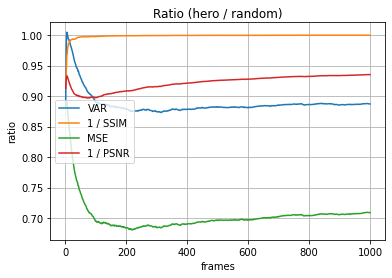

In [24]:
# ratio plots
#size = plt.rcParamsDefault["figure.figsize"]
#plt.figure(figsize=(size[0] * 2, size[1]))

for e, hero_y in hero.items():
    if e == "PSE":
        continue
    if e == "PSNR" or e == "SSIM":
        label = "1 / " + e
        ratio = random[e] / hero_y
    else:
        label = e
        ratio = hero_y / random[e]

    x = np.arange(1, len(ratio) * frame_steps + 1, frame_steps)
    plt.plot(x, ratio, label=label)

    print("{} ratio in range ({:.3f}, {:.3f}).".format(e, ratio.min(), ratio.max()))
    # if e == "VAR":
    #     print(hero_y[:10]);
    #     print(random[e][:10]);
    #     print(ratio[:10])

plt.grid(visible=True)
plt.xlabel("frames")
plt.ylabel("ratio")
plt.title("Ratio (hero / random)")
plt.legend()
plt.savefig("{}/ratio.png".format(PATH), dpi=200)
plt.show()